*Author:* Nathan Zimmerman <br>
*Date:* 2/1/2020

# Dynamic Modeling of Voltage Dropout for Electronics

**Brief:** This doc demonstrates a dynamic system model with the intent to give engineers insight into design considerations and system failures due to battery aging. Often, electrical systems will fail before the battery's advertized capacity rating is reached. A variable amount of design risk is undertaken as a design engineers attempts to "derate" a battery by some quantity to compensate for this pre-mature failure. This risk can potentially be mitigated by dynamic system modeling. This doc will outline a **dynamic circuit model** by which a supply voltage can be observed per an arbitrary dynamic load. 

## Dynamic Circuit Model:



Consider the following circuit:

<p align="center">
    <img src='images/circuit.png' align="center"></img>
</p>


The following defines the terms in the above circuit: 

$$
\begin{split}
& V_{Bat}: Battery \ Voltage \\
& R_{ESR}: Changing \ Battery \ ESR \\
& C_{Bulk}: System \ Bulk \ Capacitence \\
& V_{Supply}: System \ Supply \ Voltage \\ 
& I_{Load}: System \ Load \ Current \\  
& I_{Load} = I_{Static} + I_{Dynamic}
\end{split}
$$

Note, the failure condition of many electrical systems is defined by a dropout voltage of some critical IC (such as a microcontroller). Hence: 

$$
System \ Failure =  V_{Supply} < V_{Drop \ Out}
$$


Also note, $I_{Load}$ is approximating the system loading as a current source. In reality, it will be some combination of currents and impedances. $I_{Load}$ is broken out into the sum of $I_{Static}$ and $I_{Dynamic}$. Regarding $I_{Static}$, electronics often have a static(quiesent) current draw from passives and active components. Regarding $I_{Dynamic}$, electronics often have a dominant dynamic current pulse such as an RF transmission or a sensor measurement. A pulse from $I_{Dynamic}$ is often what eventually brings down $V_{Supply}$ below $V_{Drop \ Out}$ as $R_{ESR}$ increases as the battery ages. 


### Dynamic Model: 

This docs objective is to create a dynamics model that allows for easy simulation of an arbitrary input $I_{Load}$ and its effect on output $V_{Supply}$. Consequently, a discrete time model is desired. Via nodal equations it can be shown that the following is true: 

**Step 1:** Nodal equation 

$$
\frac{V_{Bat} - V_{Supply}}{R_{ESR}} = I_{Load} + I_{C_{Bulk}}
$$

Recall the definition of capacitence, $I_C =  V_C \cdot s \cdot C$ where $s$ is the **Laplace Transform**. 

**Step 2:** Simplification, substitution, re-aragement
$$
V_{Supply}\cdot s = \frac{V_{Bat} - V_{Supply}}{R_{ESR}\cdot C_{Bulk}} - \frac{I_{Load}}{C_{ESR}}
$$






Recall the forward difference approximation $s = (z - 1)/ \Delta T$ where $z$ is the **Z-Transform** and $\Delta T$ is the discrete timestep. Note that $z$ represents a function step advance. 

**Step 3:** Final form

$$
V_{Supply}(k + 1) = \frac{\Delta T \cdot (V_{Bat} - V_{Supply}(k))}{R_{ESR}\cdot C_{Bulk}} + V_{Supply}(k) - \frac{ \Delta T \cdot I_{Supply}(k) }{C_{Bulk}} 
$$

The above equation allows one to observe $V_{Supply}$ with respect to time for an arbitrary input $I_{Supply}$.

### Validate Dynamics Model:

LT Spice is free commercial software allows one to simulate electrical dynamic systems. [DropOutExample.asc](DropOutExample.asc) is an LT Spice simulation of this circuit and its results are shown below. 


<p align="center">
    <img src='images/lt_sim.png' align="center"></img>
</p>


With this simulation as reference, the following will demonstrate similar results using the derived equation.   




In [166]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import math
from matplotlib import animation, rc
from IPython.display import HTML
from pandas import DataFrame

In [211]:
# Define our variables 

c_bulk = 220.0 * 1e-6 # Farards
v_bat = 3.3 # Volts
r_esr = 100 # Ohms
i_dynamic = 20.0 * 1e-3 # Amps
i_static = 0 * 1e-6 # Amps
delta_t = 1.0 * 1e-4 # Seconds

In [212]:
# Define our model 

def v_model(v_i, del_t, i_load):
    return del_t * (v_bat - v_i)/(r_esr * c_bulk) + v_i - (del_t * i_load)/c_bulk 

In [215]:
# Perform simulation

v_supply = 3.3 # Starting voltage
sim_time = 3 # Time (s)
data_out = []
i_load = 0
for t in range( math.floor(sim_time / delta_t)):
    data_out.append([t*delta_t,v_supply,i_load]) # Save data 
    if( (t > np.round(2 / delta_t)-1) and (t < np.round(2.02 / delta_t)) ):
        i_load = i_dynamic # Dynamic pulse
    else:
        i_load = i_static # Static current 
    v_supply = v_model(v_supply, delta_t, i_load) # Calculate next step
data_out = np.array(data_out)

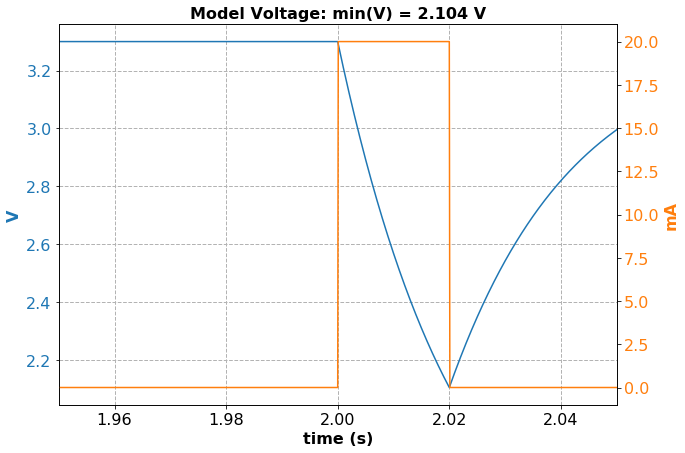

In [216]:
# Plot results 

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['axes.titleweight'] = 'bold'
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (s)')
ax1.set_ylabel('V', color='C0')
ax1.plot(data_out[:,0],data_out[:,1],color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.grid(color='0.7', linestyle='--', linewidth=1)
ax1.set_axisbelow(True)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(data_out[:,0],data_out[:,2]*1000,color='C1')
ax2.set_ylabel('mA', color='C1')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='C1')
ax1.set_xlim(1.95,2.05)
fig.set_size_inches(10,7)
plt.title('Model Voltage: min(V) = %3.3f V'%np.min(data_out[:,1]))
plt.show()

### Model Result Analysis: 

As observed in the figure above, the discrete model proposed gives one a solution similar to the LT spce simulation. $V_{Model \ min} \approx 2.104V$ in the proposed model and $V_{LT \ min} \approx 2.106V$. These differences are likely due to rise/fall time assumptions as well as the discretization method being more complex than the forward difference. None the less, the following model allows one to fairly accurately approximate the voltage drop for an arbitrary $I_{Supply}$. 

$$
V_{Supply}(k + 1) = \frac{\Delta T \cdot (V_{Bat} - V_{Supply}(k))}{R_{ESR}\cdot C_{Bulk}} + V_{Supply}(k) - \frac{ \Delta T \cdot I_{Supply}(k) }{C_{Bulk}} 
$$

